# Loading and Parsing Data

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('Assignment - Data Exploration & Modelling - Data.csv', delimiter=',', index_col=0)

df.head()


,InputC1,InputC2,InputC3,InputC4,InputC5,InputC6,InputC7,InputC8,InputC9,InputC10,...,InputA4,InputA5,InputA6,InputB1,InputB2,InputB3,InputB4,InputB5,InputB6,Target
2022-01-01 00:00:00,18.49650,18.81396,100.0696,618.6791,NaN,1931.360,7.272931,1878.295,1.549485,27.25480,...,60.10090,7.385031,7.081979,27.39823,20.89696,260.1674,2.193955,NaN,6.236635,NaN
2022-01-01 00:05:00,18.49731,18.70401,100.0715,613.7349,NaN,1929.365,7.273591,1878.252,1.552745,27.25177,...,60.09105,7.375766,7.136544,27.07825,26.92165,259.9575,2.187813,NaN,6.238485,NaN
2022-01-01 00:10:00,18.49693,18.59405,100.0733,608.7906,NaN,1924.322,7.274251,1878.209,1.556006,27.24874,...,60.08120,7.366502,7.085941,26.75828,14.01370,259.7475,2.181671,NaN,6.240336,NaN
2022-01-01 00:15:00,18.49603,18.48410,100.0751,603.8464,NaN,1919.279,7.274910,1878.167,1.559266,27.24572,...,60.07135,7.357237,6.743883,26.50328,5.78938,259.5375,2.175529,NaN,6.242187,NaN
2022-01-01 00:20:00,18.49512,18.37415,100.0770,598.9022,NaN,1914.235,7.275570,1878.124,1.562526,27.24269,...,60.06150,7.347972,6.621848,26.29828,39.27962,259.3275,2.169388,NaN,6.244037,NaN


Converting the index of the DataFrame to datetime format is crucial for time-based analysis.
This allows for easier time-based slicing, grouping, and plotting.

In [196]:
df = df.set_index(pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S'))
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 00:05:00',
               '2022-01-01 00:10:00', '2022-01-01 00:15:00',
               '2022-01-01 00:20:00', '2022-01-01 00:25:00',
               '2022-01-01 00:30:00', '2022-01-01 00:35:00',
               '2022-01-01 00:40:00', '2022-01-01 00:45:00',
               ...
               '2022-09-23 13:00:00', '2022-09-23 13:05:00',
               '2022-09-23 13:10:00', '2022-09-23 13:15:00',
               '2022-09-23 13:20:00', '2022-09-23 13:25:00',
               '2022-09-23 13:30:00', '2022-09-23 13:35:00',
               '2022-09-23 13:40:00', '2022-09-23 13:45:00'],
              dtype='datetime64[ns]', length=76474, freq=None)

-Loading additional information about variables from an Excel file.
-This information will help in understanding and interpreting the columns in the main data.
-Setting the 'Name' column as the index for variable information to facilitate easier lookups.

In [197]:
variable_info = pd.read_excel('Data_Analysis_Export_IPYNB/Biology case - Variable info_v2.xlsx', dtype='string')
variable_info = variable_info.fillna('')
variable_info = variable_info.set_index("Name")
variable_info.head()

,Description,Units,Custom Name,Location
Name,,,,
InputC1,O2 percentage in tank 1,%,O2 perc,Tank 1
InputC2,Liquid to reduce the pH in tank 1,l/h,pH regulator in flow,Tank 1
InputC3,Filtered sludge going back to tank 1,m3/h,Sludge recycle in flow,Tank 1
InputC4,Outside air tank 1,Nm3/h,Air in flow,Tank 1
InputC5,Height in tank 1,m,Content height,Tank 1


-Renaming DataFrame columns using the MultiIndex for improved clarity and organization.

-Resetting the index of variable information to create separate columns for 'Location' and 'Custom Name'. This facilitates easier reference and analysis of variable information.

-Setting the MultiIndex for variable information, dropping the redundant index column for a cleaner structure.


In [198]:
loc_name = pd.MultiIndex.from_frame(variable_info.loc[df.columns, ['Location', 'Custom Name']])
# Rename the columns
df.columns = loc_name

variable_info = variable_info.reset_index()
var_info_idx = pd.MultiIndex.from_frame(variable_info[['Location', 'Custom Name']])
variable_info = variable_info.set_index(var_info_idx, drop=True)
variable_info.head()

Name  \
Location Custom Name                       
Tank 1   O2 perc                 InputC1   
         pH regulator in flow    InputC2   
         Sludge recycle in flow  InputC3   
         Air in flow             InputC4   
         Content height          InputC5   

                                                          Description  Units  \
Location Custom Name                                                           
Tank 1   O2 perc                              O2 percentage in tank 1      %   
         pH regulator in flow       Liquid to reduce the pH in tank 1    l/h   
         Sludge recycle in flow  Filtered sludge going back to tank 1   m3/h   
         Air in flow                               Outside air tank 1  Nm3/h   
         Content height                              Height in tank 1      m   

                                            Custom Name Location  
Location Custom Name                                              
Tank 1   O2 perc                                O2 perc   Tank 1  
         pH regulator in flow      pH regulator in flow   Tank 1  
         Sludge recycle in flow  Sludge recycle in flow   Tank 1  
         Air in flow                        Air in flow   Tank 1  
         Content height                  Content height   Tank 1

# General Statistics

In [199]:
# General Statistics
general_stats = df.describe().T

# Display the general statistics in a nice readable table
table = tabulate(general_stats, headers='keys', tablefmt='fancy_grid', showindex=True, numalign="right",
                 stralign="right")

print("General Statistics:")
print(table)

General Statistics:
╒══════════════════════════════════════╤═════════╤═════════╤══════════╤═════════════╤══════════╤═════════╤═════════╤═════════╕
│                                      │   count │    mean │      std │         min │      25% │     50% │     75% │     max │
╞══════════════════════════════════════╪═════════╪═════════╪══════════╪═════════════╪══════════╪═════════╪═════════╪═════════╡
│                ('Tank 1', 'O2 perc') │   71948 │ 19.3253 │  3.07094 │     15.7764 │  17.4176 │ 18.0359 │ 18.5479 │ 25.5309 │
├──────────────────────────────────────┼─────────┼─────────┼──────────┼─────────────┼──────────┼─────────┼─────────┼─────────┤
│   ('Tank 1', 'pH regulator in flow') │   70943 │ 29.4429 │  14.3289 │    -3.44438 │  21.3977 │  29.124 │ 36.7782 │ 515.131 │
├──────────────────────────────────────┼─────────┼─────────┼──────────┼─────────────┼──────────┼─────────┼─────────┼─────────┤
│ ('Tank 1', 'Sludge recycle in flow') │   71116 │ 93.8635 │  12.3966 │    -3.92576 │  89.7

In this section, we assess data quality by calculating the percentage of missing values for each column in the DataFrame (`missing_percentage`). This metric informs us about the extent of missing data, aiding decisions on appropriate handling strategies. Additionally, we identify mode values for each column (`mode_values`). Knowing the most frequent values is valuable for imputing missing data, particularly in categorical or discrete variables. These analyses provide insights into data completeness and central tendencies, guiding subsequent preprocessing steps in the data analysis pipeline.

In [200]:
# Percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Display the mode for each column
mode_values = df.mode().iloc[0]

print("\nPercentage of Missing Values:")
print(missing_percentage)
print("\nMode Values:")
print(mode_values)



Percentage of Missing Values:
Location  Custom Name           
Tank 1    O2 perc                    5.918351
          pH regulator in flow       7.232523
          Sludge recycle in flow     7.006303
          Air in flow                0.101995
          Content height            11.785705
          pH measurement FR          7.270445
          pH                         7.351518
          O2 measurement FR          7.382901
          O2 dissolved               7.314904
          Temperature                7.416900
Exit      Sludge concentration       7.326673
          Conductivity               2.467505
          NO3 Dissolved             56.691163
Tank 2    O2 perc                    5.951042
          pH regulator in flow       6.909538
          Sludge recycle in flow     6.977535
          Air in flow                0.099380
          Content height            13.234563
          pH measurement FR          7.313597
          pH                         6.990611
          O2 mea

# Box Plots

This code cell is dedicated to exploring outliers in numerical columns using boxplots. The select_dtypes(include=np.number) function is used to filter and select only numerical columns from the DataFrame. Then, for each numerical column, a boxplot is created using Seaborn (sns.boxplot). Boxplots are effective visualizations for identifying the distribution of data, central tendency, and potential outliers.

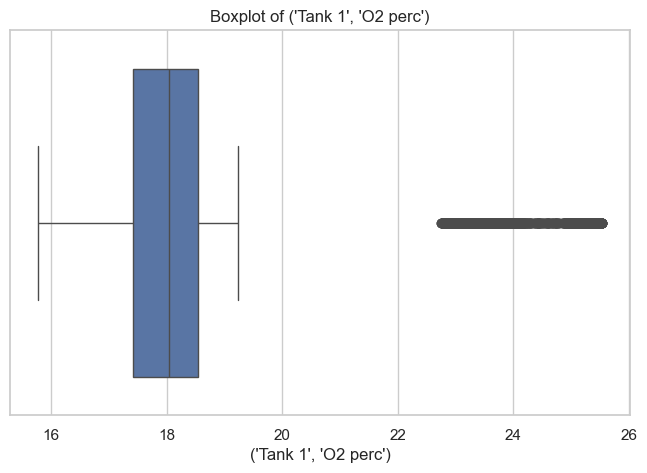

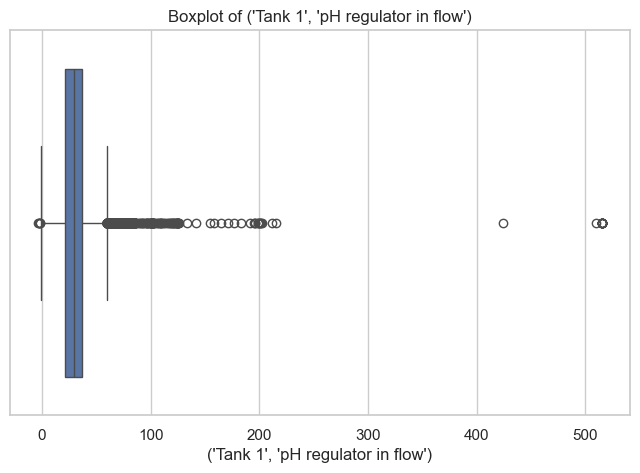

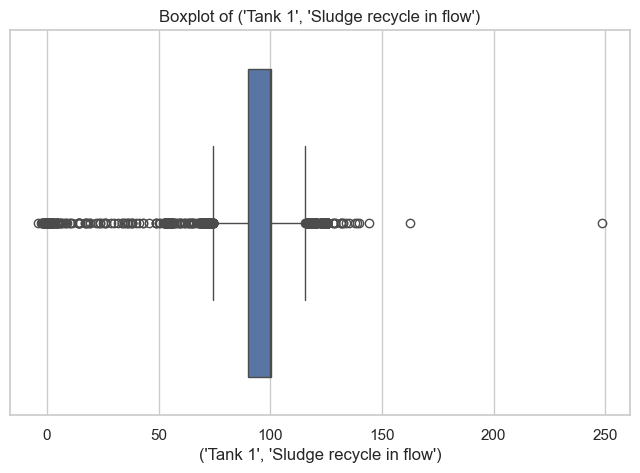

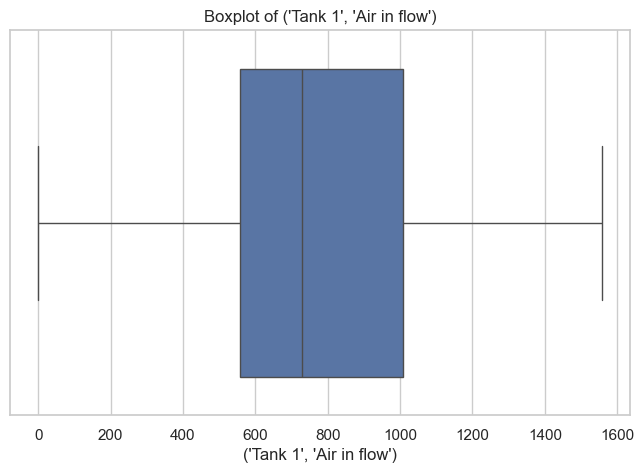

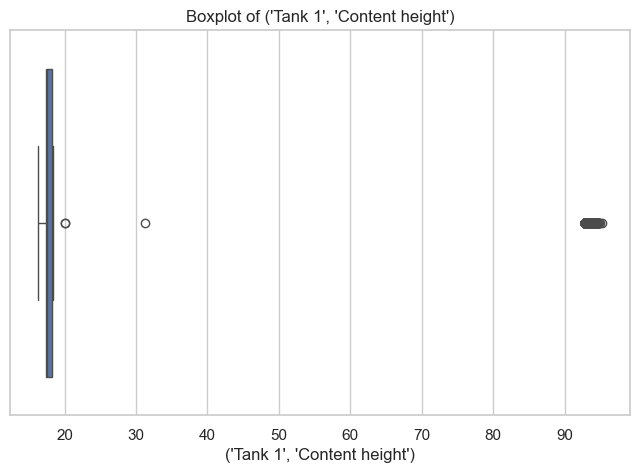

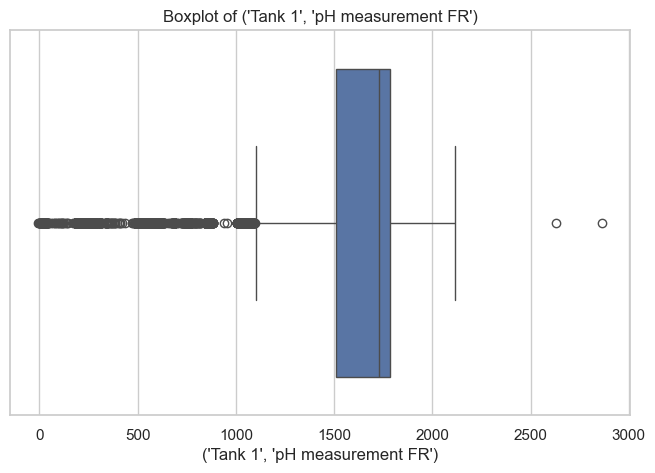

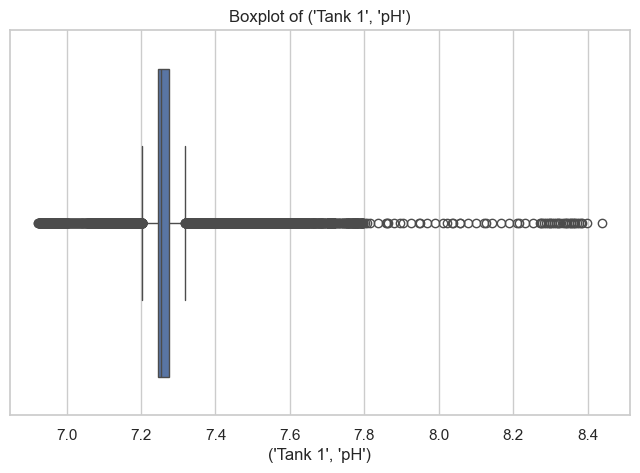

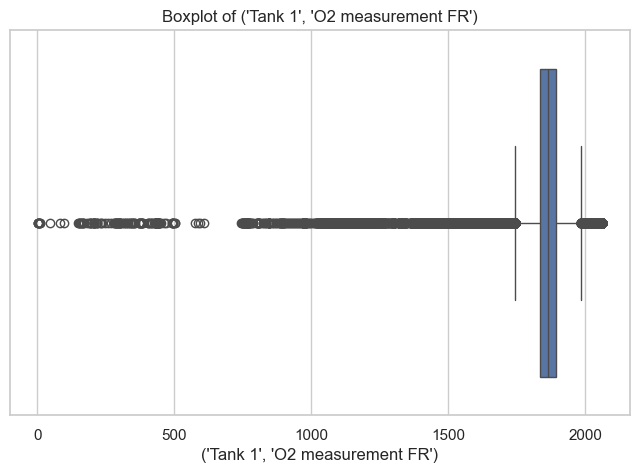

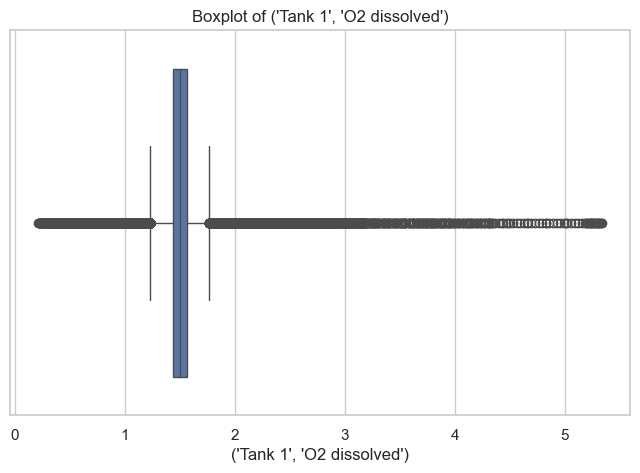

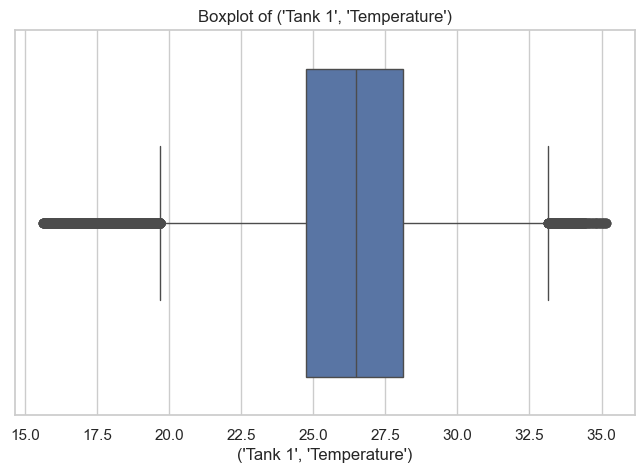

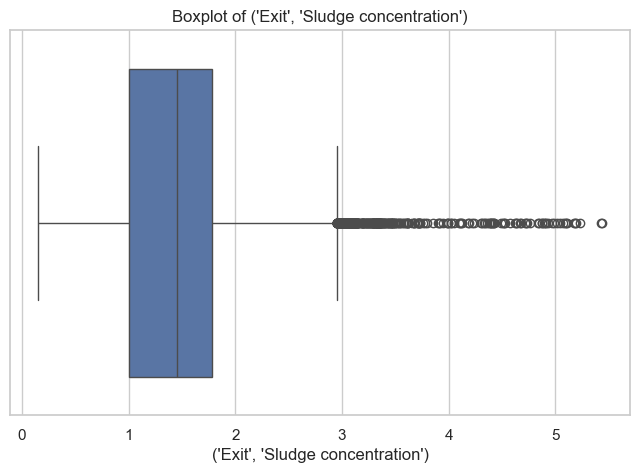

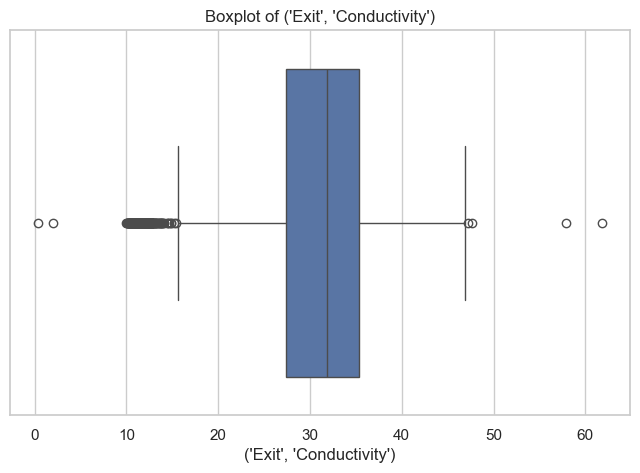

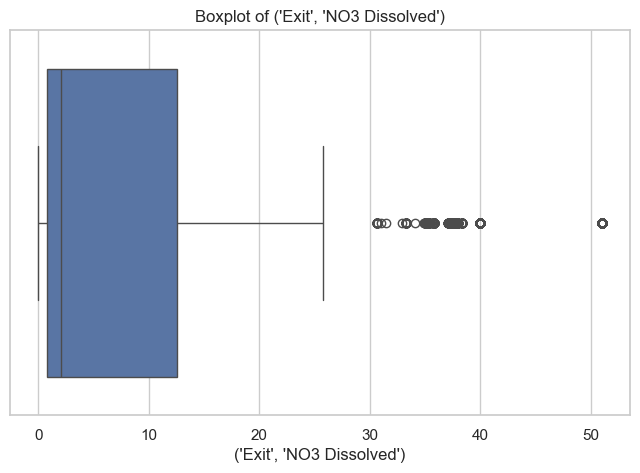

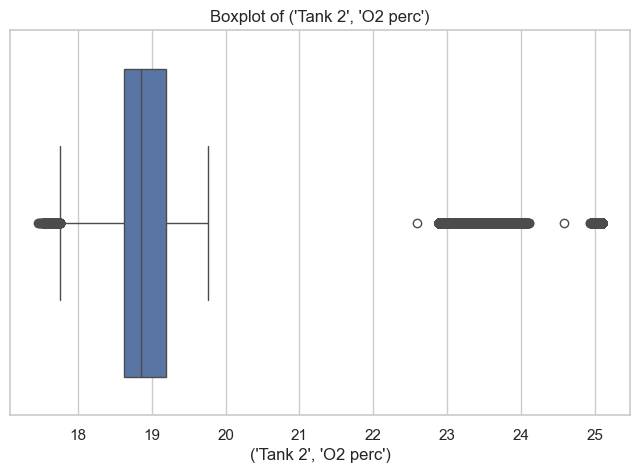

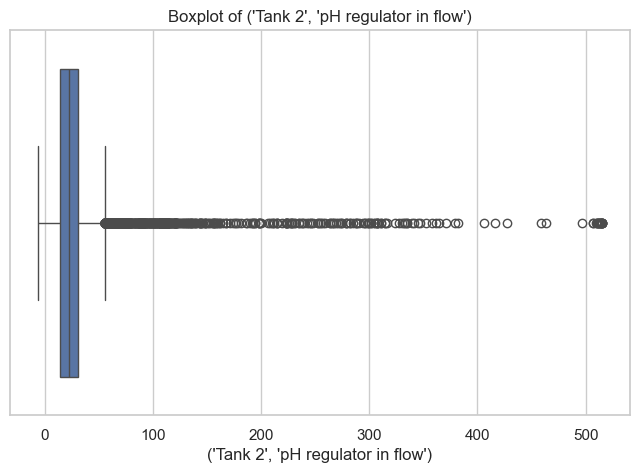

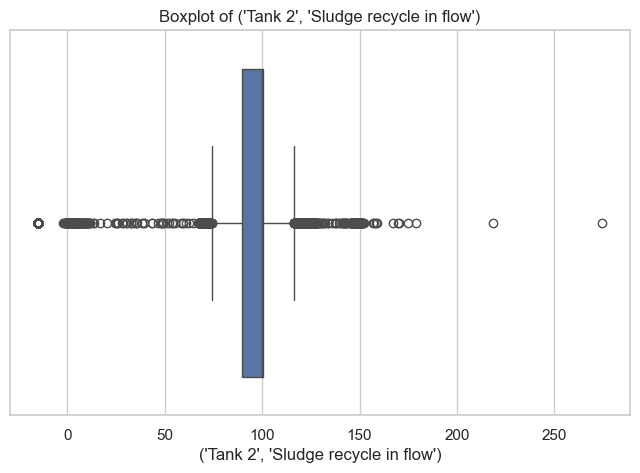

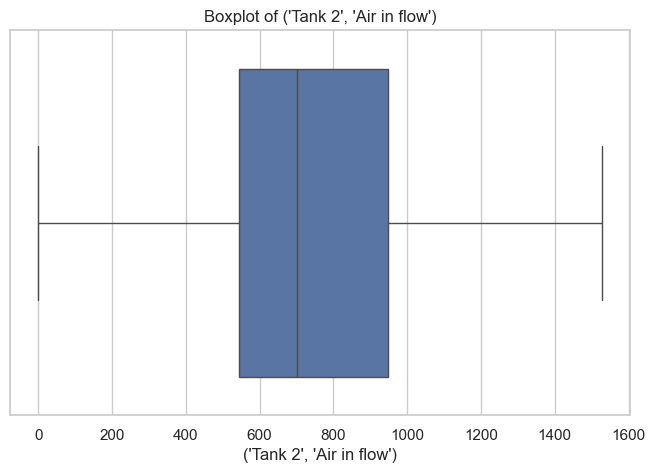

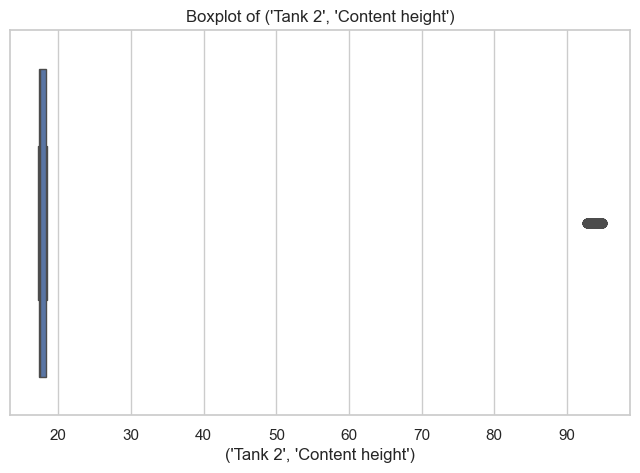

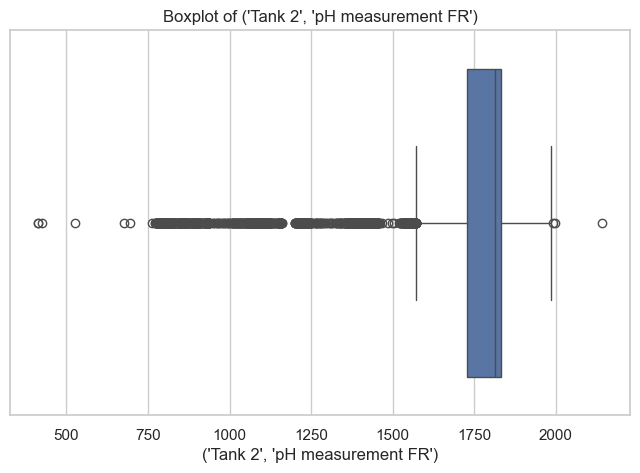

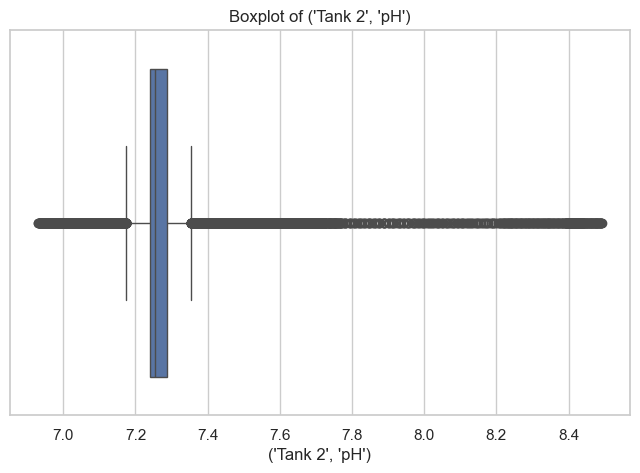

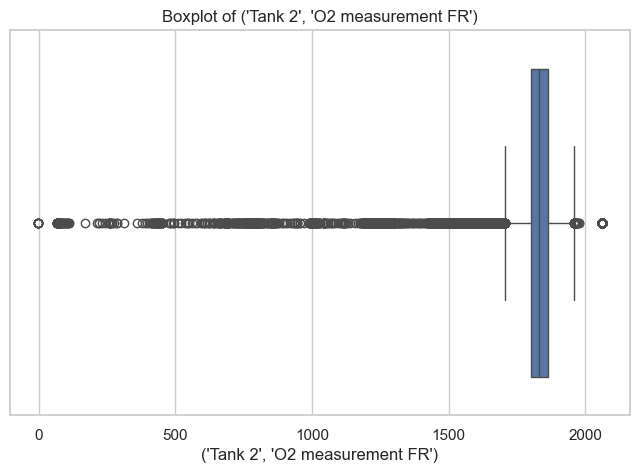

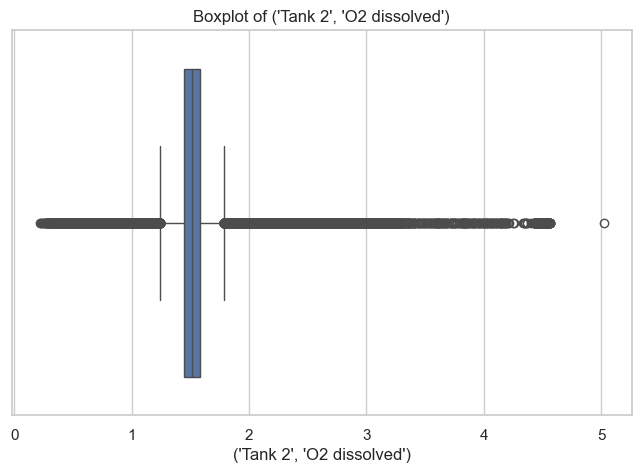

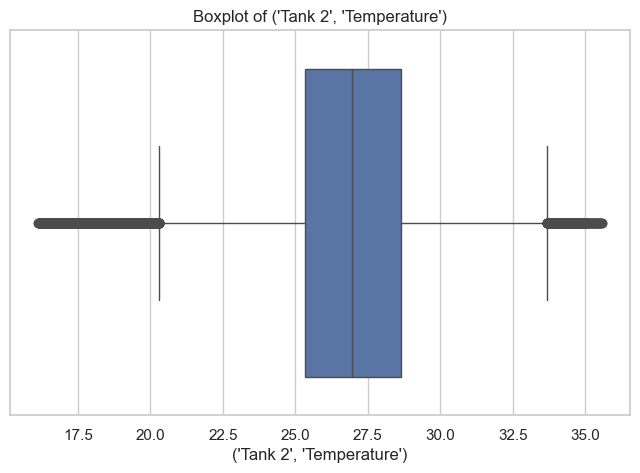

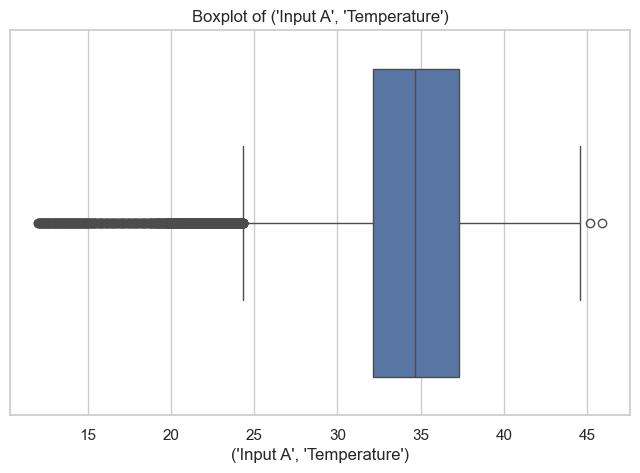

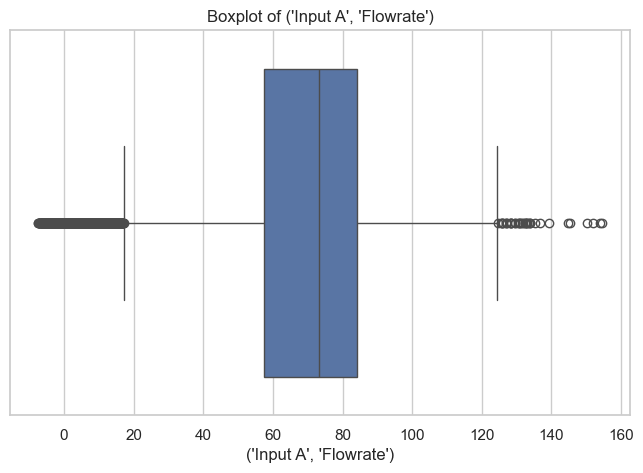

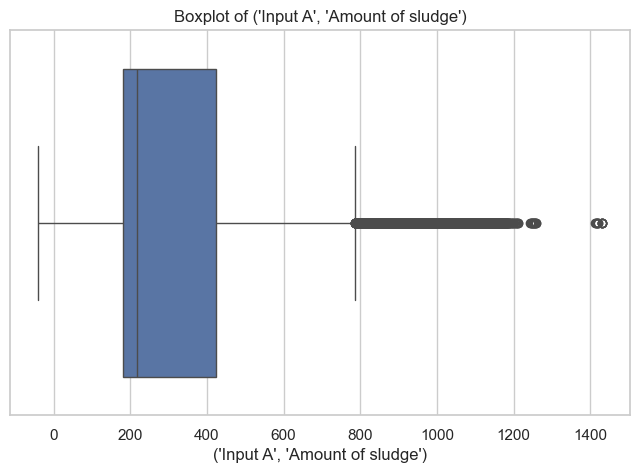

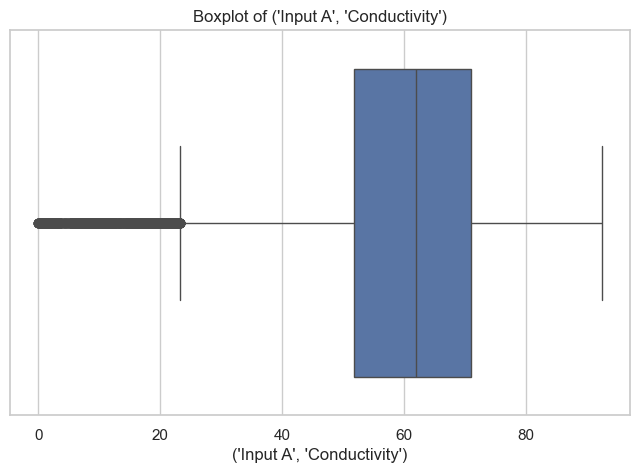

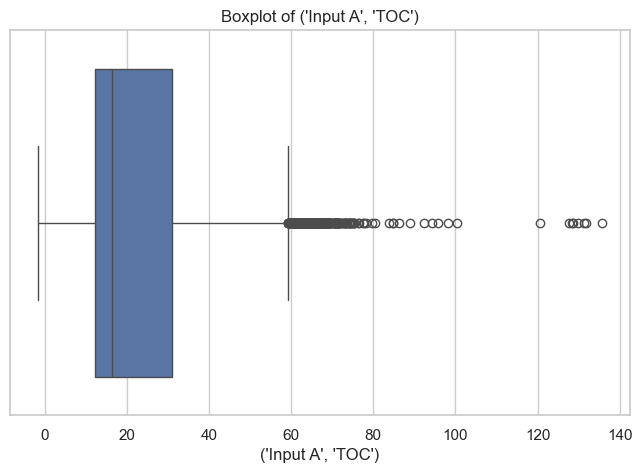

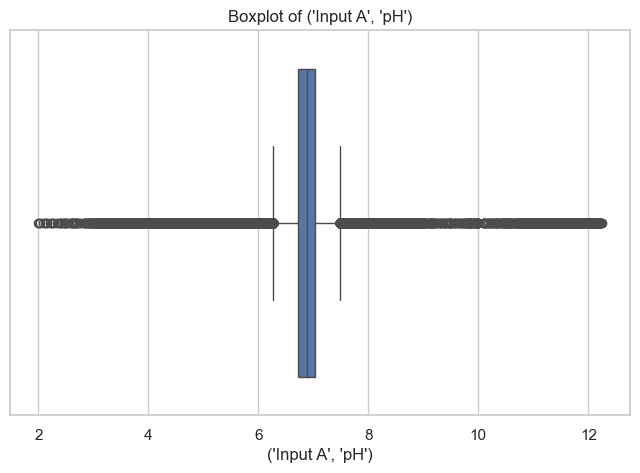

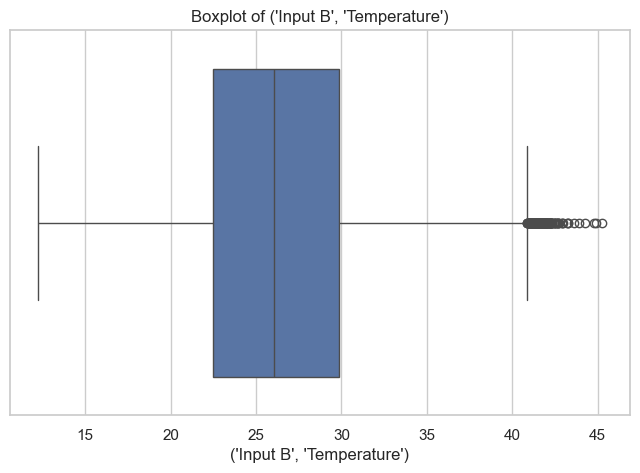

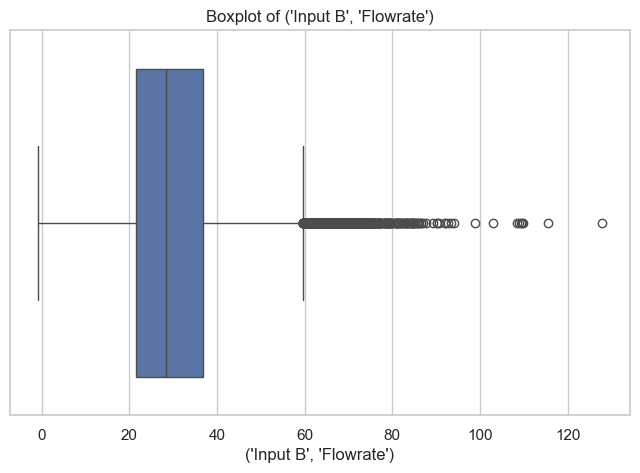

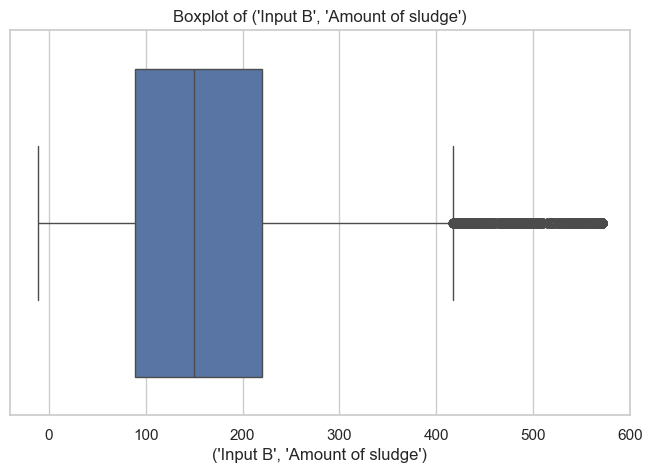

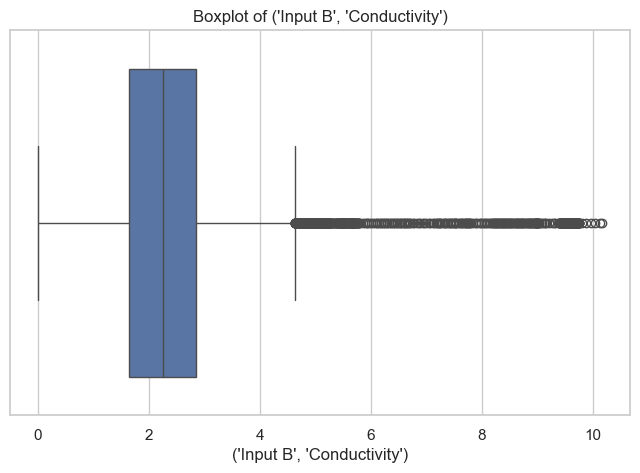

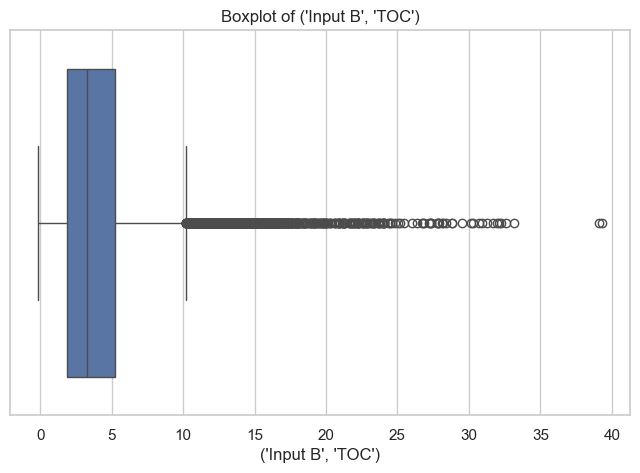

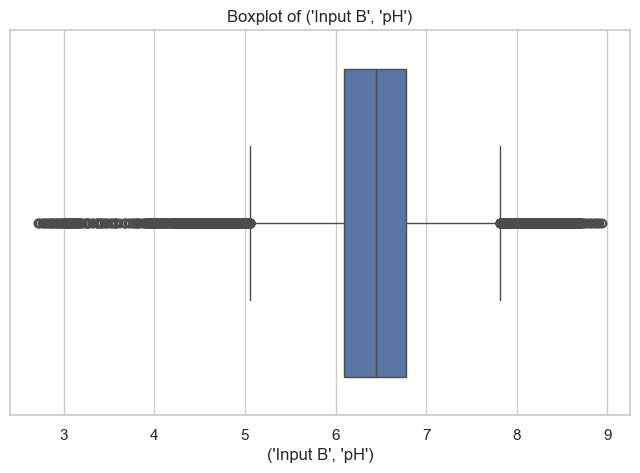

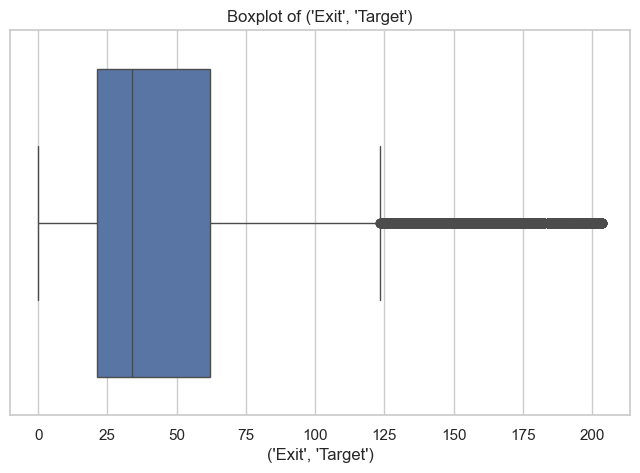

In [201]:
# Exploring outliers using boxplots

numerical_columns = df.select_dtypes(include=np.number).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


# Outlier Detection and Removal

In [202]:
df

Location               Tank 1                                              \
Custom Name           O2 perc pH regulator in flow Sludge recycle in flow   
2022-01-01 00:00:00  18.49650             18.81396              100.06960   
2022-01-01 00:05:00  18.49731             18.70401              100.07150   
2022-01-01 00:10:00  18.49693             18.59405              100.07330   
2022-01-01 00:15:00  18.49603             18.48410              100.07510   
2022-01-01 00:20:00  18.49512             18.37415              100.07700   
...                       ...                  ...                    ...   
2022-09-23 13:25:00  17.86954             41.94464               89.89435   
2022-09-23 13:30:00  17.88018             40.87782               89.92362   
2022-09-23 13:35:00  17.89081             39.81099               89.95290   
2022-09-23 13:40:00  17.90145             38.74416               89.98218   
2022-09-23 13:45:00  17.91208             38.58984               89.99812   

Location                                                                    \
Custom Name         Air in flow Content height pH measurement FR        pH   
2022-01-01 00:00:00    618.6791            NaN          1931.360  7.272931   
2022-01-01 00:05:00    613.7349            NaN          1929.365  7.273591   
2022-01-01 00:10:00    608.7906            NaN          1924.322  7.274251   
2022-01-01 00:15:00    603.8464            NaN          1919.279  7.274910   
2022-01-01 00:20:00    598.9022            NaN          1914.235  7.275570   
...                         ...            ...               ...       ...   
2022-09-23 13:25:00    805.8918       17.45585          1462.229  7.598161   
2022-09-23 13:30:00    804.2576       17.45406          1461.738  7.599618   
2022-09-23 13:35:00    802.6233       17.45228          1460.959  7.601076   
2022-09-23 13:40:00    800.9891       17.45049          1462.083  7.602533   
2022-09-23 13:45:00    799.3548       17.44870          1463.145  7.603990   

Location                                                        ...  \
Custom Name         O2 measurement FR O2 dissolved Temperature  ...   
2022-01-01 00:00:00          1878.295     1.549485    27.25480  ...   
2022-01-01 00:05:00          1878.252     1.552745    27.25177  ...   
2022-01-01 00:10:00          1878.209     1.556006    27.24874  ...   
2022-01-01 00:15:00          1878.167     1.559266    27.24572  ...   
2022-01-01 00:20:00          1878.124     1.562526    27.24269  ...   
...                               ...          ...         ...  ...   
2022-09-23 13:25:00          1883.041     1.639308    19.44436  ...   
2022-09-23 13:30:00          1883.005     1.581313    19.44209  ...   
2022-09-23 13:35:00          1882.969     1.523319    19.43982  ...   
2022-09-23 13:40:00          1882.934     1.465324    19.43755  ...   
2022-09-23 13:45:00          1882.898     1.407330    19.43527  ...   

Location                 Input A                          Input B            \
Custom Name         Conductivity        TOC        pH Temperature  Flowrate   
2022-01-01 00:00:00     60.10090   7.385031  7.081979    27.39823  20.89696   
2022-01-01 00:05:00     60.09105   7.375766  7.136544    27.07825  26.92165   
2022-01-01 00:10:00     60.08120   7.366502  7.085941    26.75828  14.01370   
2022-01-01 00:15:00     60.07135   7.357237  6.743883    26.50328   5.78938   
2022-01-01 00:20:00     60.06150   7.347972  6.621848    26.29828  39.27962   
...                          ...        ...       ...         ...       ...   
2022-09-23 13:25:00     51.72038   3.863174  7.156402    27.69638  37.34892   
2022-09-23 13:30:00     51.14077  16.219060  7.148751    27.69767  35.89980   
2022-09-23 13:35:00     50.56117  14.821500  7.141101    27.69895  47.51368   
2022-09-23 13:40:00     49.98157  12.261280  7.133451    27.70023  48.20868   
2022-09-23 13:45:00     57.16953  16.359960  8.468385    27.70151  58.19659   

Location                       

# I wanted to get rid of the outliers using the IQR method, but I found that the outliers were not really outliers, but rather the data was just very noisy. I decided to investigate a bit more what could be considered an outlier and remove them and use interpolation to fill in the missing values to smooth out the data.

In [203]:
# clean_data = df.copy()
# # Calculate the percentage of outliers for each column
# Q1 = clean_data[numerical_columns].quantile(0.25)
# Q3 = clean_data[numerical_columns].quantile(0.75)
# IQR = Q3 - Q1
# 
# # Define the lower and upper bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# 
# # Identify outliers for each row
# outliers = (clean_data[numerical_columns] < lower_bound) | (clean_data[numerical_columns] > upper_bound)
# 
# outliers_count = outliers.sum()
# print("Number of outliers for each column:")
# print(outliers_count)
# 
# # Remove outliers using the IQR method and display the count again
# df_no_outliers_iqr = clean_data[~((clean_data[numerical_columns] < lower_bound) | (clean_data[numerical_columns] > upper_bound)).any(axis=1)]
# 


In [204]:
clean_data = df.copy()
# Remove rows where at least one variable is negative or zero
clean_data = clean_data.loc[~(clean_data <= 0).any(axis=1)]
print(f"Removing rows with at least one nonpositive variable: {df.shape[0] - clean_data.shape[0]} rows were removed. ")

# Handle the tank1 content height outliers:
remove = (clean_data[('Tank 1', 'Content height')] > 25)
clean_data.loc[remove] = np.nan
print(f"Setting values with Tank 1 Content height > 25m to NaN: {remove.sum()} observations were affected.")

# Handle the tank2 content height outliers:
remove = (clean_data[('Tank 2', 'Content height')] > 25)
clean_data.loc[remove] = np.nan
print(f"Setting values with Tank 2 Content height > 25m to NaN: {remove.sum()} observations were affected.")

# Handle the Tank1 Sludge Recycle In Flow outliers:
remove = (clean_data[('Tank 1', 'Sludge recycle in flow')] > 150)
clean_data.loc[remove] = np.nan
print(f"Setting values with Tank 1 Sludge recycle in flow > 150m to NaN: {remove.sum()} observations were affected.")

# Handle the Tank2 Sludge Recycle In Flow outliers:
remove = (clean_data[('Tank 2', 'Sludge recycle in flow')] > 200)
clean_data.loc[remove] = np.nan
print(f"Setting values with Tank 2 Sludge recycle in flow > 200m to NaN: {remove.sum()} observations were affected.")

Removing rows with at least one nonpositive variable: 7346 rows were removed. 
Setting values with Tank 1 Content height > 25m to NaN: 7893 observations were affected.
Setting values with Tank 2 Content height > 25m to NaN: 5132 observations were affected.
Setting values with Tank 1 Sludge recycle in flow > 150m to NaN: 1 observations were affected.
Setting values with Tank 2 Sludge recycle in flow > 200m to NaN: 0 observations were affected.


In [205]:
clean_data

Location               Tank 1                                              \
Custom Name           O2 perc pH regulator in flow Sludge recycle in flow   
2022-01-01 00:00:00  18.49650             18.81396              100.06960   
2022-01-01 00:05:00  18.49731             18.70401              100.07150   
2022-01-01 00:10:00  18.49693             18.59405              100.07330   
2022-01-01 00:15:00  18.49603             18.48410              100.07510   
2022-01-01 00:20:00  18.49512             18.37415              100.07700   
...                       ...                  ...                    ...   
2022-09-23 13:25:00  17.86954             41.94464               89.89435   
2022-09-23 13:30:00  17.88018             40.87782               89.92362   
2022-09-23 13:35:00  17.89081             39.81099               89.95290   
2022-09-23 13:40:00  17.90145             38.74416               89.98218   
2022-09-23 13:45:00  17.91208             38.58984               89.99812   

Location                                                                    \
Custom Name         Air in flow Content height pH measurement FR        pH   
2022-01-01 00:00:00    618.6791            NaN          1931.360  7.272931   
2022-01-01 00:05:00    613.7349            NaN          1929.365  7.273591   
2022-01-01 00:10:00    608.7906            NaN          1924.322  7.274251   
2022-01-01 00:15:00    603.8464            NaN          1919.279  7.274910   
2022-01-01 00:20:00    598.9022            NaN          1914.235  7.275570   
...                         ...            ...               ...       ...   
2022-09-23 13:25:00    805.8918       17.45585          1462.229  7.598161   
2022-09-23 13:30:00    804.2576       17.45406          1461.738  7.599618   
2022-09-23 13:35:00    802.6233       17.45228          1460.959  7.601076   
2022-09-23 13:40:00    800.9891       17.45049          1462.083  7.602533   
2022-09-23 13:45:00    799.3548       17.44870          1463.145  7.603990   

Location                                                        ...  \
Custom Name         O2 measurement FR O2 dissolved Temperature  ...   
2022-01-01 00:00:00          1878.295     1.549485    27.25480  ...   
2022-01-01 00:05:00          1878.252     1.552745    27.25177  ...   
2022-01-01 00:10:00          1878.209     1.556006    27.24874  ...   
2022-01-01 00:15:00          1878.167     1.559266    27.24572  ...   
2022-01-01 00:20:00          1878.124     1.562526    27.24269  ...   
...                               ...          ...         ...  ...   
2022-09-23 13:25:00          1883.041     1.639308    19.44436  ...   
2022-09-23 13:30:00          1883.005     1.581313    19.44209  ...   
2022-09-23 13:35:00          1882.969     1.523319    19.43982  ...   
2022-09-23 13:40:00          1882.934     1.465324    19.43755  ...   
2022-09-23 13:45:00          1882.898     1.407330    19.43527  ...   

Location                 Input A                          Input B            \
Custom Name         Conductivity        TOC        pH Temperature  Flowrate   
2022-01-01 00:00:00     60.10090   7.385031  7.081979    27.39823  20.89696   
2022-01-01 00:05:00     60.09105   7.375766  7.136544    27.07825  26.92165   
2022-01-01 00:10:00     60.08120   7.366502  7.085941    26.75828  14.01370   
2022-01-01 00:15:00     60.07135   7.357237  6.743883    26.50328   5.78938   
2022-01-01 00:20:00     60.06150   7.347972  6.621848    26.29828  39.27962   
...                          ...        ...       ...         ...       ...   
2022-09-23 13:25:00     51.72038   3.863174  7.156402    27.69638  37.34892   
2022-09-23 13:30:00     51.14077  16.219060  7.148751    27.69767  35.89980   
2022-09-23 13:35:00     50.56117  14.821500  7.141101    27.69895  47.51368   
2022-09-23 13:40:00     49.98157  12.261280  7.133451    27.70023  48.20868   
2022-09-23 13:45:00     57.16953  16.359960  8.468385    27.70151  58.19659   

Location                       

In [206]:
# # Calculate the percentage of outliers for each column
# # Identify outliers for each row
# outliers = (df_no_outliers_iqr[numerical_columns] < lower_bound) | (df_no_outliers_iqr[numerical_columns] > upper_bound)
# 
# outliers_count = outliers.sum()
# print("Number of outliers for each column:")
# print(outliers_count)

# Remove unnecessary columns
# We remove the following variables due to the following reasons:
* `NO3 Dissolved` - Too many missing values
* `Tank2 O2 measurement FR` - Not relevant to the process
* `Tank1 O2 measurement FR` - Not relevant to the process
* `Tank2 pH measurement FR` - Not relevant to the process
* `Tank1 pH measurement FR` - Not relevant to the process

In [207]:
# Remove unnecessary columns
remove_vars = [("Exit", "NO3 Dissolved"), ("Tank 2", "pH measurement FR"),
               ("Tank 2", "O2 measurement FR"), ("Tank 1", "pH measurement FR"),
               ("Tank 1", "O2 measurement FR")]
clean_data = clean_data.drop(remove_vars, axis=1)

# Missing Values

In [208]:
clean_data


Location               Tank 1                                              \
Custom Name           O2 perc pH regulator in flow Sludge recycle in flow   
2022-01-01 00:00:00  18.49650             18.81396              100.06960   
2022-01-01 00:05:00  18.49731             18.70401              100.07150   
2022-01-01 00:10:00  18.49693             18.59405              100.07330   
2022-01-01 00:15:00  18.49603             18.48410              100.07510   
2022-01-01 00:20:00  18.49512             18.37415              100.07700   
...                       ...                  ...                    ...   
2022-09-23 13:25:00  17.86954             41.94464               89.89435   
2022-09-23 13:30:00  17.88018             40.87782               89.92362   
2022-09-23 13:35:00  17.89081             39.81099               89.95290   
2022-09-23 13:40:00  17.90145             38.74416               89.98218   
2022-09-23 13:45:00  17.91208             38.58984               89.99812   

Location                                                               \
Custom Name         Air in flow Content height        pH O2 dissolved   
2022-01-01 00:00:00    618.6791            NaN  7.272931     1.549485   
2022-01-01 00:05:00    613.7349            NaN  7.273591     1.552745   
2022-01-01 00:10:00    608.7906            NaN  7.274251     1.556006   
2022-01-01 00:15:00    603.8464            NaN  7.274910     1.559266   
2022-01-01 00:20:00    598.9022            NaN  7.275570     1.562526   
...                         ...            ...       ...          ...   
2022-09-23 13:25:00    805.8918       17.45585  7.598161     1.639308   
2022-09-23 13:30:00    804.2576       17.45406  7.599618     1.581313   
2022-09-23 13:35:00    802.6233       17.45228  7.601076     1.523319   
2022-09-23 13:40:00    800.9891       17.45049  7.602533     1.465324   
2022-09-23 13:45:00    799.3548       17.44870  7.603990     1.407330   

Location                                        Exit               ...  \
Custom Name         Temperature Sludge concentration Conductivity  ...   
2022-01-01 00:00:00    27.25480             1.432856     33.50126  ...   
2022-01-01 00:05:00    27.25177             1.433269     33.48506  ...   
2022-01-01 00:10:00    27.24874             1.433681     33.46886  ...   
2022-01-01 00:15:00    27.24572             1.434094     33.45267  ...   
2022-01-01 00:20:00    27.24269             1.434507     33.43647  ...   
...                         ...                  ...          ...  ...   
2022-09-23 13:25:00    19.44436             1.331053     31.84225  ...   
2022-09-23 13:30:00    19.44209             1.328054     31.86338  ...   
2022-09-23 13:35:00    19.43982             1.325055     31.88450  ...   
2022-09-23 13:40:00    19.43755             1.322055     31.90563  ...   
2022-09-23 13:45:00    19.43527             1.319922     31.92675  ...   

Location                 Input A                          Input B            \
Custom Name         Conductivity        TOC        pH Temperature  Flowrate   
2022-01-01 00:00:00     60.10090   7.385031  7.081979    27.39823  20.89696   
2022-01-01 00:05:00     60.09105   7.375766  7.136544    27.07825  26.92165   
2022-01-01 00:10:00     60.08120   7.366502  7.085941    26.75828  14.01370   
2022-01-01 00:15:00     60.07135   7.357237  6.743883    26.50328   5.78938   
2022-01-01 00:20:00     60.06150   7.347972  6.621848    26.29828  39.27962   
...                          ...        ...       ...         ...       ...   
2022-09-23 13:25:00     51.72038   3.863174  7.156402    27.69638  37.34892   
2022-09-23 13:30:00     51.14077  16.219060  7.148751    27.69767  35.89980   
2022-09-23 13:35:00     50.56117  14.821500  7.141101    27.69895  47.51368   
2022-09-23 13:40:00     49.98157  12.261280  7.133451    27.70023  48.20868   
2022-09-23 13:45:00     57.16953  16.359960  8.468385    27.70151  58.19659   

Location                                                 

In [229]:
df_to_clean = clean_data.copy()
# Count missing values for each column
missing_count = df_to_clean.isnull().sum()
missing_count = missing_count[missing_count > 0]
print(missing_count)


Location  Custom Name           
Tank 1    O2 perc                   16318
          pH regulator in flow      17354
          Sludge recycle in flow    17265
          Air in flow               13101
          Content height            21428
          pH                        17405
          O2 dissolved              17433
          Temperature               17455
Exit      Sludge concentration      17393
          Conductivity              13922
Tank 2    O2 perc                   16314
          pH regulator in flow      17244
          Sludge recycle in flow    17244
          Air in flow               13099
          Content height            22542
          pH                        17263
          O2 dissolved              13779
          Temperature               17377
Input A   Temperature               13164
          Flowrate                  35834
          Amount of sludge          13142
          Conductivity              20843
          TOC                       19533
 

The interpolate method is applied to the DataFrame (df_to_clean), specifying the interpolation method as 'linear', the axis along which the interpolation is performed as 0 (indicating along the rows), and setting a limit for the maximum number of consecutive NaN values to be filled. The limit helps us prevent overfilling in cases where there are long sequences of missing values.

In [230]:
max_timestamp_gap = 24  # 120 Minutes
df_clean = df_to_clean.interpolate('linear', axis=0, limit=max_timestamp_gap)

# Print the number of missing values after filling NaN values
print(f'Number of missing values after filling NaN values: {df_clean.isnull().sum()}')

Number of missing values after filling NaN values: Location  Custom Name           
Tank 1    O2 perc                   16174
          pH regulator in flow      17287
          Sludge recycle in flow    17173
          Air in flow               12994
          Content height            21355
          pH                        17305
          O2 dissolved              17316
          Temperature               17361
Exit      Sludge concentration      17267
          Conductivity              13808
Tank 2    O2 perc                   16193
          pH regulator in flow      17134
          Sludge recycle in flow    17149
          Air in flow               12987
          Content height            22296
          pH                        17173
          O2 dissolved              13642
          Temperature               17282
Input A   Temperature               13033
          Flowrate                  32073
          Amount of sludge          13039
          Conductivity            

In [231]:
df_clean

Location               Tank 1                                              \
Custom Name           O2 perc pH regulator in flow Sludge recycle in flow   
2022-01-01 00:00:00  18.49650             18.81396              100.06960   
2022-01-01 00:05:00  18.49731             18.70401              100.07150   
2022-01-01 00:10:00  18.49693             18.59405              100.07330   
2022-01-01 00:15:00  18.49603             18.48410              100.07510   
2022-01-01 00:20:00  18.49512             18.37415              100.07700   
...                       ...                  ...                    ...   
2022-09-23 13:25:00  17.86954             41.94464               89.89435   
2022-09-23 13:30:00  17.88018             40.87782               89.92362   
2022-09-23 13:35:00  17.89081             39.81099               89.95290   
2022-09-23 13:40:00  17.90145             38.74416               89.98218   
2022-09-23 13:45:00  17.91208             38.58984               89.99812   

Location                                                               \
Custom Name         Air in flow Content height        pH O2 dissolved   
2022-01-01 00:00:00    618.6791            NaN  7.272931     1.549485   
2022-01-01 00:05:00    613.7349            NaN  7.273591     1.552745   
2022-01-01 00:10:00    608.7906            NaN  7.274251     1.556006   
2022-01-01 00:15:00    603.8464            NaN  7.274910     1.559266   
2022-01-01 00:20:00    598.9022            NaN  7.275570     1.562526   
...                         ...            ...       ...          ...   
2022-09-23 13:25:00    805.8918       17.45585  7.598161     1.639308   
2022-09-23 13:30:00    804.2576       17.45406  7.599618     1.581313   
2022-09-23 13:35:00    802.6233       17.45228  7.601076     1.523319   
2022-09-23 13:40:00    800.9891       17.45049  7.602533     1.465324   
2022-09-23 13:45:00    799.3548       17.44870  7.603990     1.407330   

Location                                        Exit               ...  \
Custom Name         Temperature Sludge concentration Conductivity  ...   
2022-01-01 00:00:00    27.25480             1.432856     33.50126  ...   
2022-01-01 00:05:00    27.25177             1.433269     33.48506  ...   
2022-01-01 00:10:00    27.24874             1.433681     33.46886  ...   
2022-01-01 00:15:00    27.24572             1.434094     33.45267  ...   
2022-01-01 00:20:00    27.24269             1.434507     33.43647  ...   
...                         ...                  ...          ...  ...   
2022-09-23 13:25:00    19.44436             1.331053     31.84225  ...   
2022-09-23 13:30:00    19.44209             1.328054     31.86338  ...   
2022-09-23 13:35:00    19.43982             1.325055     31.88450  ...   
2022-09-23 13:40:00    19.43755             1.322055     31.90563  ...   
2022-09-23 13:45:00    19.43527             1.319922     31.92675  ...   

Location                 Input A                          Input B            \
Custom Name         Conductivity        TOC        pH Temperature  Flowrate   
2022-01-01 00:00:00     60.10090   7.385031  7.081979    27.39823  20.89696   
2022-01-01 00:05:00     60.09105   7.375766  7.136544    27.07825  26.92165   
2022-01-01 00:10:00     60.08120   7.366502  7.085941    26.75828  14.01370   
2022-01-01 00:15:00     60.07135   7.357237  6.743883    26.50328   5.78938   
2022-01-01 00:20:00     60.06150   7.347972  6.621848    26.29828  39.27962   
...                          ...        ...       ...         ...       ...   
2022-09-23 13:25:00     51.72038   3.863174  7.156402    27.69638  37.34892   
2022-09-23 13:30:00     51.14077  16.219060  7.148751    27.69767  35.89980   
2022-09-23 13:35:00     50.56117  14.821500  7.141101    27.69895  47.51368   
2022-09-23 13:40:00     49.98157  12.261280  7.133451    27.70023  48.20868   
2022-09-23 13:45:00     57.16953  16.359960  8.468385    27.70151  58.19659   

Location                                                 

### Making some cuts in the data

* We remove the observations where `Target` is missing, because we cannot do anything with these rows.


In [232]:
rows_before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=[('Exit', 'Target')])
rows_after = df_clean.shape[0]

print(f"Removed {rows_before - rows_after} rows where 'Exit' target is NaN. Rows remaining {rows_after}")


Removed 17851 rows where 'Exit' target is NaN. Rows remaining 51277


To even further improve the quality of the data instead of dropping the rows with missing values we can fill them with the mean or mode of the column but based on the Location. This way we can fill the missing values with more accurate values.

In [238]:
def remove_missing_values(df):
    for location in df.columns.levels[0]:
        for column in df[location].columns:
            if df[location][column].dtype == object:
                df.loc[:, (location, column)] = df[location][column].fillna(df[location][column].mode().iloc[0])
            elif df[location][column].dtype in [int, float]:
                df.loc[:, (location, column)] = df[location][column].fillna(df[location][column].mean())

    # df.dropna(inplace=True)
    return df


# Example usage:
df_clean = remove_missing_values(df_clean)

print(f'Number of missing values after filling NaN values: {df_clean.isnull().sum().sum()}')


Number of missing values after filling NaN values: 0


In [242]:
print(f'Number of rows left: {df_clean.shape[0]}')

Number of rows left: 51277


# Histograms
The histograms provide a visual representation of the data distribution for each variable.

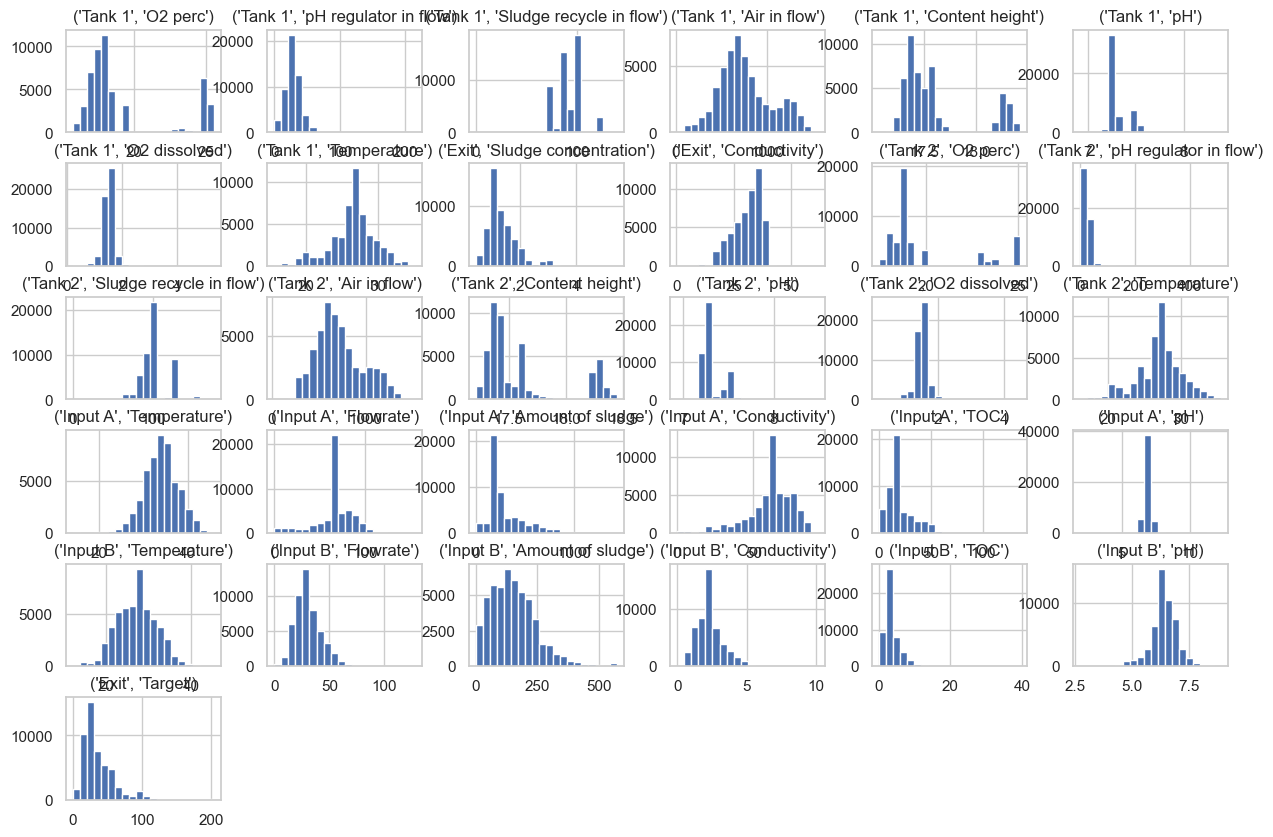

In [243]:
# Explore data distributions using histograms
df_clean.hist(bins=20, figsize=(15, 10))
plt.show()


# Just wanted to make sure

In [249]:
# Check for negative values in the entire DataFrame
negative_values = df_clean.lt(0)

# Check if any negative values exist in the entire DataFrame
any_negative_values = negative_values.any().any()

if any_negative_values:
    print("There are negative values in the DataFrame.")
else:
    print("There are no negative values in the DataFrame.")


There are no negative values in the DataFrame.


* Trend Component: The long-term movement or direction in the data.
* Seasonal Component: Repeating patterns or cycles that occur at regular intervals.
* Residual Component: The remaining variation in the data after removing the trend and seasonality.
Analyzing these components can be valuable for time series forecasting, anomaly detection, and understanding the overall behavior of the data. The plot generated allows for visually inspecting and interpreting these components. For example, we can identify whether there is a clear trend or seasonality in the "Exit" target column, which can inform further analysis or modeling decisions.

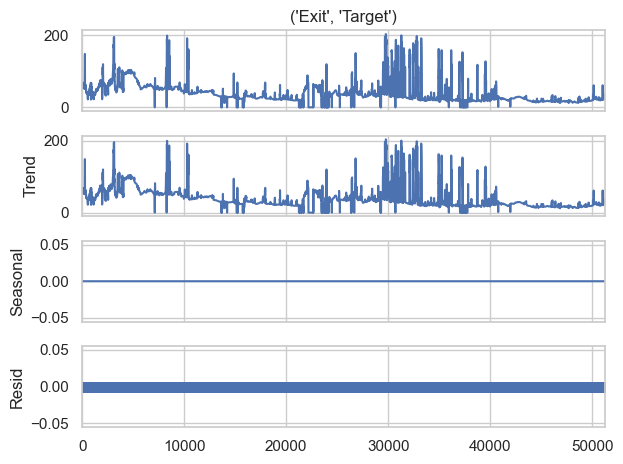

In [244]:
# Reset the index to make the current index a regular column
df_reset_index = df_clean.reset_index()

target_column = df_reset_index[('Exit', 'Target')]

result = seasonal_decompose(target_column, model='additive', period=1)
result.plot()
plt.show()

# Correlation


# Target Correlation
We analyze the correlation between the target variable ('Exit', 'Target') and other columns in the cleaned DataFrame (df_clean). In the "Target Correlation with 'Exit' Target" section, we observe the strength and direction of correlations for each variable. For instance, 'O2 perc' in 'Tank 1' shows a positive correlation (0.28) with the target, indicating that higher oxygen levels in 'Tank 1' are associated with a higher 'Exit' target.

In [245]:
# Calculate the correlation with all other columns
target_variable = df_clean[('Exit', 'Target')]

target_correlation = df_clean.corrwith(target_variable)

print("Target Correlation with 'Exit' Target:")
print(target_correlation)


Target Correlation with 'Exit' Target:
Location  Custom Name           
Tank 1    O2 perc                   0.279919
          pH regulator in flow     -0.151934
          Sludge recycle in flow    0.177884
          Air in flow              -0.035457
          Content height           -0.032963
          pH                       -0.321236
          O2 dissolved              0.086533
          Temperature               0.101412
Exit      Sludge concentration      0.160508
          Conductivity              0.022206
Tank 2    O2 perc                   0.237349
          pH regulator in flow      0.048047
          Sludge recycle in flow   -0.046034
          Air in flow              -0.026949
          Content height           -0.039032
          pH                       -0.302754
          O2 dissolved              0.117379
          Temperature               0.093620
Input A   Temperature              -0.031075
          Flowrate                  0.040232
          Amount of sludge  

# Linear Correlation Matrix
Moving on to the "Linear Correlation Matrix," we gain a broader understanding of how all variables correlate with each other. Notably, some variables exhibit strong correlations, such as 'Temperature' in 'Tank 1' and 'Temperature' in 'Input A,' suggesting a relationship between these features.

One interesting observation is the correlation between 'Sludge concentration' in 'Exit' and 'Sludge recycle in flow' in 'Tank 1' (0.34). This might imply that the amount of sludge recycled in 'Tank 1' is positively linked to the sludge concentration in the exit.

In [246]:
# Calculate linear correlations for the entire DataFrame
linear_correlation_matrix = df_clean.corr()

print("Linear Correlation Matrix:")
print(linear_correlation_matrix)


Linear Correlation Matrix:
Location                           Tank 1                       \
Custom Name                       O2 perc pH regulator in flow   
Location Custom Name                                             
Tank 1   O2 perc                 1.000000            -0.274290   
         pH regulator in flow   -0.274290             1.000000   
         Sludge recycle in flow  0.150890             0.024913   
         Air in flow            -0.345518             0.637719   
         Content height         -0.366659            -0.178987   
         pH                     -0.287839             0.317175   
         O2 dissolved            0.049544            -0.151171   
         Temperature            -0.399301            -0.108018   
Exit     Sludge concentration   -0.133003             0.154832   
         Conductivity            0.394147             0.158478   
Tank 2   O2 perc                 0.975624            -0.237342   
         pH regulator in flow   -0.048848        

These correlation insights are valuable for feature selection in modeling. For instance, if a variable shows a high correlation with the target, it could be a key factor in predicting the target variable accurately. On the other hand, understanding correlations between features helps in identifying potential multicollinearity, which can impact the performance of certain models.

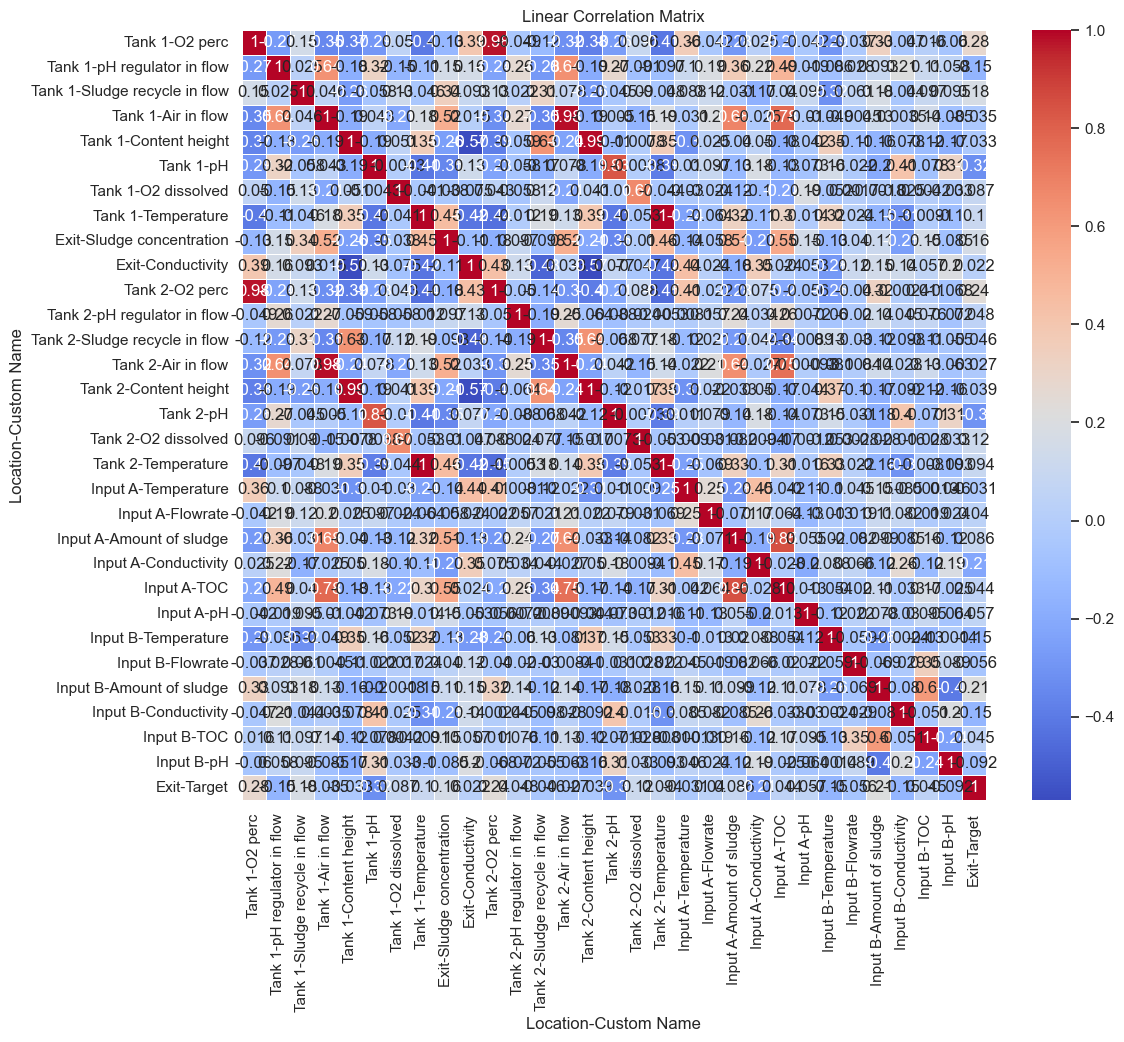

In [247]:
# Create a figure
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(linear_correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# Set plot title
plt.title('Linear Correlation Matrix')

plt.show()


# I have chosen Gradient Boosting for its ability to handle non-linear relationships, its ensemble learning nature that enhances predictive performance, robustness to outliers, and versatility across different types of data. The trade-off is a slightly more complex model compared to linear methods, but the benefits often outweigh this consideration, especially in scenarios where achieving the best predictive accuracy is crucial. Which is the case here.

In [257]:
df_clean[('Exit', 'Target')]

2022-01-17 17:10:00    67.15141
2022-01-17 17:15:00    67.14989
2022-01-17 17:20:00    67.14836
2022-01-17 17:25:00    67.14684
2022-01-17 17:30:00    67.14531
                         ...   
2022-09-23 13:25:00    37.12706
2022-09-23 13:30:00    37.12669
2022-09-23 13:35:00    37.12632
2022-09-23 13:40:00    37.12595
2022-09-23 13:45:00    37.12558
Name: (Exit, Target), Length: 51277, dtype: float64

This code cell prepares the dataset for machine learning by separating the target variable ('Exit' in 'Target') into 'y' and extracting features ('X'). The dataset is then split into training and testing sets. I have performed Feature selection using the F-regression method with SelectKBest, retaining the top 12 features. The names of these selected features are displayed. This process streamlines the dataset for subsequent machine learning modeling, focusing on the most influential features in predicting the target variable.

In [278]:
y = df_clean[('Exit', 'Target')]

# Drop the target variable column from the second level of the MultiIndex
X = df_clean[df_clean.columns[~df_clean.columns.get_level_values(1).isin(['Target'])]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=12)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
best_features = selector.get_support(indices=True)

# Display the selected feature names
selected_feature_names = X.columns[best_features].tolist()
print("Selected Features:", selected_feature_names)

Selected Features: [('Tank 1', 'O2 perc'), ('Tank 1', 'pH regulator in flow'), ('Tank 1', 'Sludge recycle in flow'), ('Tank 1', 'pH'), ('Exit', 'Sludge concentration'), ('Tank 2', 'O2 perc'), ('Tank 2', 'pH'), ('Tank 2', 'O2 dissolved'), ('Input A', 'Conductivity'), ('Input B', 'Temperature'), ('Input B', 'Amount of sludge'), ('Input B', 'Conductivity')]


In [279]:
y = df_clean[('Exit', 'Target')]

selected_features = [('Tank 1', 'O2 perc'), ('Tank 1', 'pH regulator in flow'), ('Tank 1', 'Sludge recycle in flow'), ('Tank 1', 'pH'), ('Exit', 'Sludge concentration'), ('Tank 2', 'O2 perc'), ('Tank 2', 'pH'), ('Tank 2', 'O2 dissolved'), ('Input A', 'Conductivity'), ('Input B', 'Temperature'), ('Input B', 'Amount of sludge'), ('Input B', 'Conductivity')]

X = df_clean[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [280]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")

Mean Squared Error on Test Set: 276.07628320496343


# Hypertuning
I tried implementing a GridSearchCV to find the best hyperparameters for the model, but it was taking too long to run. I decided to just use the default parameters for the model and leave the code just to show how I have done it. Theoretically hypertuning could improve the performance of various models tremendously especially in the case of Gradient Boosting.

In [282]:
model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [289]:
# Define the hyperparameter grid
hyperparameters = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 4, 5],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

gridsearch = GridSearchCV(model, hyperparameters, cv=5)

gridsearch.fit(X_train, y_train)

print(f'Best hyperparameters: {gridsearch.best_params_}')


KeyboardInterrupt: 

In [ ]:
predictGb = gridsearch.predict(X_test)

mseH = mean_squared_error(y_test, predictGb)

print(f'MSE after Hypertuning: {mseH}')

In [ ]:
# Create a new DataFrame for the next 4 hours at 5-minute intervals
new_timestamps = pd.date_range(df_clean.index[-1], periods=49, freq='5T')[1:]
new_df = pd.DataFrame(index=new_timestamps, columns=X.columns)

# Use the trained model to predict the target variable
new_predictions = model.predict(new_df)

# Create a new DataFrame for the predictions
predictions_df = pd.DataFrame(data=new_predictions, index=new_timestamps, columns=[('Exit', 'Target')])

predictions_df

# Conclusion
In conclusion, this task involved several key steps. Initially, the dataset was loaded, and missing values were addressed by imputing them with linear interpolation and later filling them with the mean/mode. Exploratory data analysis, including the examination of outliers and data distributions, provided insights into the dataset's characteristics. Correlation analysis revealed relationships between variables, and the selection of relevant features for machine learning models was performed.

Furthermore, we divided the dataset into training and testing sets, and feature selection was applied to identify the most impactful variables for predicting the target variable ('Exit' in 'Target'). The chosen features are expected to enhance model performance. Overall, these steps lay the foundation for subsequent machine learning modeling to predict the 'Exit' target variable based on the selected features.